# Result Analysis Notebook

In [1]:
import os
import sys
import json
import random
import lifelines
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import SimpleITK as sitk

from sklearn import metrics
from ast import literal_eval

from my_lib.utils import *
from my_lib.viz_utils import *
from my_lib.data_utils import *

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)

# ----------------------------------------

#everything that has to do with plotting goes here below

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'retina'

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.jet
my_jet = cmap(np.arange(cmap.N))
my_jet[:,-1] = np.linspace(0, 1, cmap.N)
my_jet = ListedColormap(my_jet)

## ----------------------------------------

import seaborn as sns
sns.set(style = "whitegrid")

Python version               :  3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
Numpy version                :  1.18.5


In [2]:
data_base_path = '../data'
output_base_path = '../outputs'

## ----------------------------------------

dataset_name = 'nsclc-radiomics'

preproc_dataset_name = dataset_name + '_preprocessed'
preproc_dataset_path = os.path.join(data_base_path, preproc_dataset_name)
preproc_data_path = os.path.join(preproc_dataset_path, 'nrrd')

csv_out_name = 'nsclc-radiomics_preproc_details.csv'
dataset_csv_path = os.path.join(data_base_path, csv_out_name)

## ----------------------------------------

# analysis results
res_csv_name = 'res.csv'
res_csv_path = os.path.join(output_base_path, res_csv_name)
res_df = pd.read_csv(res_csv_path, dtype = object)

## ----------------------------------------

# clinical data
clinical_csv_name = 'nsclc-radiomics_clinical.csv'
clinical_csv_path = os.path.join(data_base_path, clinical_csv_name)

clinical_df = pd.read_csv(clinical_csv_path)

## ----------------------------------------

tuning_csv_name = 'radboud_hosny_baseline.csv'
tuning_csv_path = os.path.join(data_base_path, tuning_csv_name)

tuning_df = pd.read_csv(tuning_csv_path)

## ----------------------------------------

res_df = pd.merge(left = res_df,
                  right = clinical_df, 
                  how = "inner",
                  on = "PatientID")

# read lists as such and not strings
res_df["CNN_output_raw"] = res_df["CNN_output_raw"].apply(literal_eval)

## ----------------------------------------
# add variables expressing survival for survival analysis

fup = lambda pat_surv, time : pat_surv > time

res_df["surv_1y"] = fup(res_df["Survival.time"].values, 365).astype(np.int)
res_df["surv_2y"] = fup(res_df["Survival.time"].values, 2*365).astype(np.int)
res_df["surv_3y"] = fup(res_df["Survival.time"].values, 3*365).astype(np.int)

res_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PatientID                   415 non-null    object 
 1   StudyInstanceUID            415 non-null    object 
 2   SeriesInstanceUID_CT        415 non-null    object 
 3   SeriesInstanceUID_RTSTRUCT  415 non-null    object 
 4   CNN_output_raw              415 non-null    object 
 5   CNN_output_argmax           415 non-null    object 
 6   baseline_output_raw         203 non-null    object 
 7   baseline_output_argmax      203 non-null    object 
 8   surv2yr                     203 non-null    object 
 9   age                         393 non-null    float64
 10  clinical.T.Stage            415 non-null    float64
 11  Clinical.N.Stage            415 non-null    int64  
 12  Clinical.M.Stage            415 non-null    int64  
 13  Overall.Stage               414 non

---

## Hosny et Al. - Study Replication

Drop all the columns for which no `baseline_output_raw` data is available (i.e., limit the analysis to the sub-cohort used in Hosny et Al.). After this operation, only around 200 entries should be kept (211 minus the missing subjects or the ones for which some problem arose during pre-processing).

In [3]:
replication_df = res_df[~res_df["baseline_output_raw"].isna()]
replication_df["baseline_output_raw"] = replication_df["baseline_output_raw"].apply(literal_eval)

replication_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 1 to 405
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PatientID                   203 non-null    object 
 1   StudyInstanceUID            203 non-null    object 
 2   SeriesInstanceUID_CT        203 non-null    object 
 3   SeriesInstanceUID_RTSTRUCT  203 non-null    object 
 4   CNN_output_raw              203 non-null    object 
 5   CNN_output_argmax           203 non-null    object 
 6   baseline_output_raw         203 non-null    object 
 7   baseline_output_argmax      203 non-null    object 
 8   surv2yr                     203 non-null    object 
 9   age                         203 non-null    float64
 10  clinical.T.Stage            203 non-null    float64
 11  Clinical.N.Stage            203 non-null    int64  
 12  Clinical.M.Stage            203 non-null    int64  
 13  Overall.Stage               203 non

---

### Cohort Viz

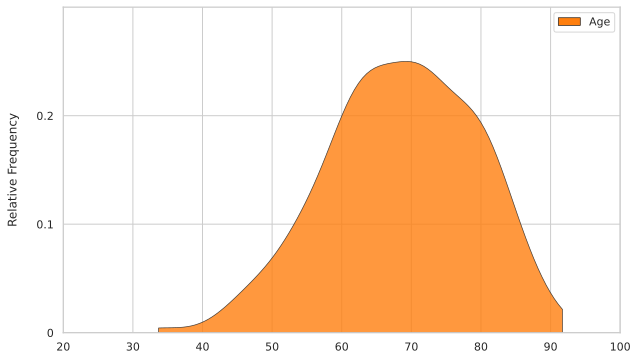

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

replication_df_filt_age = replication_df[~replication_df["age"].isna()]

attr_list = [(replication_df_filt_age["age"].values).tolist(),
            ]

attr_names = ["Age",
             ]

colors = ["tab:orange"]

leg = plot_distr(axis = ax,
                 colors = colors,
                 attr_list = attr_list,
                 attr_names = attr_names,
                 xlim = [20, 100])

_ = plt.legend(handles = leg)

In [5]:
replication_df.columns

Index(['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID_CT',
       'SeriesInstanceUID_RTSTRUCT', 'CNN_output_raw', 'CNN_output_argmax',
       'baseline_output_raw', 'baseline_output_argmax', 'surv2yr', 'age',
       'clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage',
       'Overall.Stage', 'Histology', 'gender', 'Survival.time',
       'deadstatus.event', 'surv_1y', 'surv_2y', 'surv_3y'],
      dtype='object')

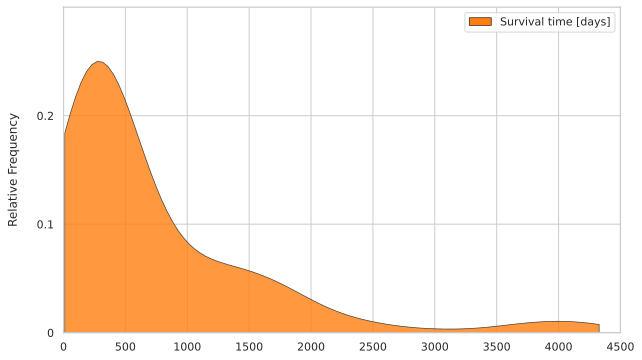

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

replication_df_filt_surv = replication_df[~replication_df["Survival.time"].isna()]

attr_list = [(replication_df_filt_surv["Survival.time"].values).tolist(),
            ]

attr_names = ["Survival time [days]",
             ]

colors = ["tab:orange"]

leg = plot_distr(axis = ax,
                 colors = colors,
                 attr_list = attr_list,
                 attr_names = attr_names,
                 xlim = [0, 4500])

_ = plt.legend(handles = leg)

---

### ROC AUC

In [7]:
# replication
y_true = replication_df["surv2yr"].astype(np.int).values
y_pred = np.stack(replication_df["CNN_output_raw"].values)

fpr, tpr, thr_roc = metrics.roc_curve(y_true, y_pred[:, 1])
prc, rec, thr_pr = metrics.precision_recall_curve(y_true, y_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)
pr_auc = metrics.auc(rec, prc)

print("ROC AUC: %g"%(roc_auc))
print("PR AUC: %g"%(pr_auc))

ROC AUC: 0.675175
PR AUC: 0.491364


In [8]:
# Hosny et Al. model
y_pred_baseline = np.stack(replication_df["baseline_output_raw"].values)

fpr_base, tpr_base, thr_roc_base = metrics.roc_curve(y_true, y_pred_baseline[:, 1])

prc_base, rec_base, thr_pr_base = metrics.precision_recall_curve(y_true, y_pred_baseline[:, 1])

roc_auc_baseline = metrics.auc(fpr_base, tpr_base)
pr_auc_baseline = metrics.auc(rec_base, prc_base)

print("ROC AUC: %g"%(roc_auc_baseline))
print("PR AUC: %g"%(pr_auc_baseline))

ROC AUC: 0.69662
PR AUC: 0.487667


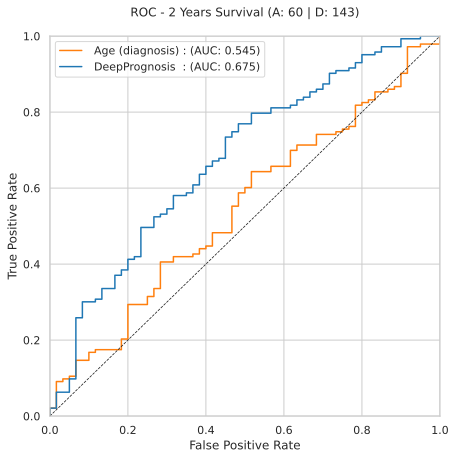

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))

sub_df = replication_df[~replication_df["age"].isna()]

alive_2y = np.sum(sub_df["surv_2y"].values)
dead_2y = len(sub_df) - alive_2y

colors = ["tab:orange",
          "tab:blue"]

get_roc_fig(axis = ax,
            colors = colors,
            event = 1 - sub_df["surv_2y"].values,
            event_name = "2 Years Survival (A: %g | D: %g)"%(alive_2y, dead_2y),
            predictors_list = [sub_df["age"].values,
                               np.stack(sub_df["CNN_output_raw"])[:, 0],
                              ],
            predictors_names = [" Age (diagnosis)",
                                " DeepPrognosis "],
           )

---

### KM Survival Curves

In [10]:
replication_df["surv_prob"] = np.stack(replication_df["CNN_output_raw"])[:, 0]

surv_thresh_q = replication_df["surv_prob"].quantile([0.1, 0.5, 0.9])
surv_thresh_q = surv_thresh_q.values

# median computed of Radboud (n=104)
median_tuning = tuning_df["logit_0"].quantile([0.5])
median_tuning = median_tuning.values[0]

## ----------------------------------------

surv_q1 = replication_df[replication_df["surv_prob"] <= median_tuning]
surv_q2 = replication_df[replication_df["surv_prob"] > median_tuning]

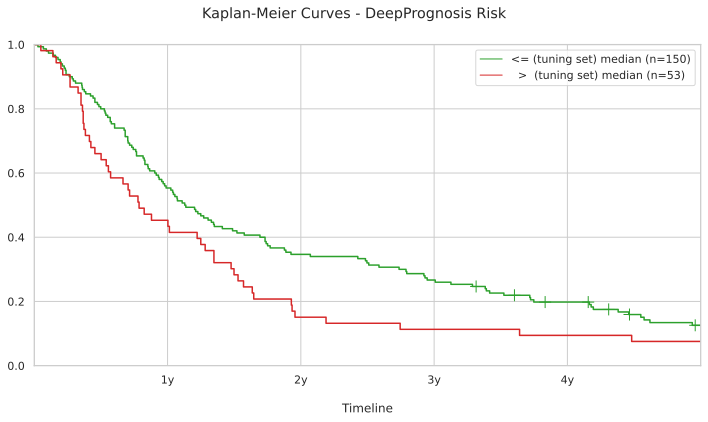

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

subgroups_to_plot = [surv_q1, surv_q2]

subgroup_labels = ["<= (tuning set) median (n=%g)"%(len(surv_q1)),
                   "  >  (tuning set) median (n=%g)"%(len(surv_q2))]

subgroup_colors = ['tab:green', 'tab:red']

leg_list = plot_km(axis = ax,
                   subgroups_to_plot = subgroups_to_plot,
                   labels = subgroup_labels,
                   colors = subgroup_colors)

plt.legend(leg_list, subgroup_labels)
fig.suptitle("Kaplan-Meier Curves - DeepPrognosis Risk")
fig.tight_layout(rect = [0, 0., 1, 0.995])

---

## Hosny et Al. - Further Validation (New Cohort)

In [12]:
clinical_csv_name = 'nscls-radiomics_clinical.csv'
clinical_csv_path = os.path.join(data_base_path, clinical_csv_name)

clinical_df = pd.read_csv(clinical_csv_path)

clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PatientID         422 non-null    object 
 1   age               400 non-null    float64
 2   clinical.T.Stage  421 non-null    float64
 3   Clinical.N.Stage  422 non-null    int64  
 4   Clinical.M.Stage  422 non-null    int64  
 5   Overall.Stage     421 non-null    object 
 6   Histology         380 non-null    object 
 7   gender            422 non-null    object 
 8   Survival.time     422 non-null    int64  
 9   deadstatus.event  422 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 33.1+ KB


In [13]:
tmp = res_df.filter(['PatientID',
                     'StudyInstanceUID',
                     'SeriesInstanceUID_CT', 
                     'SeriesInstanceUID_RTSTRUCT',
                     'CNN_output_raw',
                     'CNN_output_argmax',
                     'baseline_output_raw'])

extension_df = pd.merge(left = tmp,
                        right = clinical_df, 
                        how = "inner",
                        on = "PatientID")


extension_df = extension_df[extension_df["baseline_output_raw"].isna()]

## ----------------------------------------
# add variables expressing survival for survival analysis

fup = lambda pat_surv, time : pat_surv > time

extension_df["surv_1y"] = fup(extension_df["Survival.time"].values, 365).astype(np.int)
extension_df["surv_2y"] = fup(extension_df["Survival.time"].values, 2*365).astype(np.int)
extension_df["surv_3y"] = fup(extension_df["Survival.time"].values, 3*365).astype(np.int)

extension_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 414
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PatientID                   212 non-null    object 
 1   StudyInstanceUID            212 non-null    object 
 2   SeriesInstanceUID_CT        212 non-null    object 
 3   SeriesInstanceUID_RTSTRUCT  212 non-null    object 
 4   CNN_output_raw              212 non-null    object 
 5   CNN_output_argmax           212 non-null    object 
 6   baseline_output_raw         0 non-null      object 
 7   age                         190 non-null    float64
 8   clinical.T.Stage            212 non-null    float64
 9   Clinical.N.Stage            212 non-null    int64  
 10  Clinical.M.Stage            212 non-null    int64  
 11  Overall.Stage               211 non-null    object 
 12  Histology                   172 non-null    object 
 13  gender                      212 non

--- 

### Cohort Viz

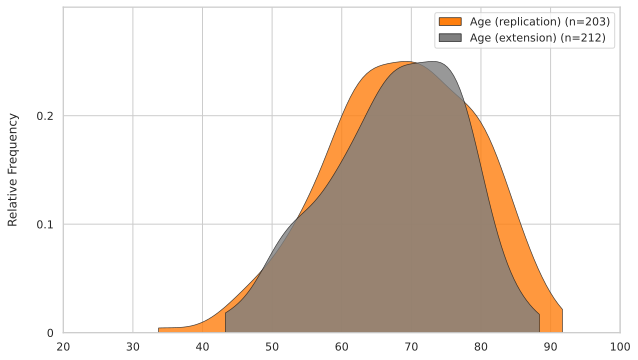

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

extension_df_filt_age = extension_df[~extension_df["age"].isna()]

attr_list = [(replication_df_filt_age["age"].values).tolist(),
             (extension_df_filt_age["age"].values).tolist(),
            ]

attr_names = ["Age (replication) (n=%g)"%(len(replication_df)),
              "Age (extension) (n=%g)"%(len(extension_df)),
             ]

colors = ["tab:orange",
          "tab:gray",
         ]

leg = plot_distr(axis = ax,
                 colors = colors,
                 attr_list = attr_list,
                 attr_names = attr_names, 
                 xlim = [20, 100])

_ = plt.legend(handles = leg)

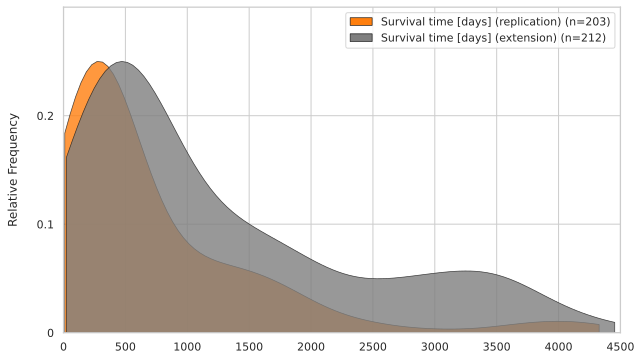

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

extension_df_filt_surv = extension_df[~extension_df["Survival.time"].isna()]

attr_list = [(replication_df_filt_surv["Survival.time"].values).tolist(),
             (extension_df_filt_surv["Survival.time"].values).tolist(),
            ]

attr_names = ["Survival time [days] (replication) (n=%g)"%(len(replication_df)),
              "Survival time [days] (extension) (n=%g)"%(len(extension_df)),
             ]

colors = ["tab:orange",
          "tab:gray",
         ]

leg = plot_distr(axis = ax,
                 colors = colors,
                 attr_list = attr_list,
                 attr_names = attr_names,
                 xlim = [0, 4500])

_ = plt.legend(handles = leg)

---

### ROC AUC

In [16]:
# extension
y_true = extension_df["surv_2y"].astype(np.int).values
y_pred = np.stack(extension_df["CNN_output_raw"].values)

fpr, tpr, thr_roc = metrics.roc_curve(y_true, y_pred[:, 1])
prc, rec, thr_pr = metrics.precision_recall_curve(y_true, y_pred[:, 1])

roc_auc = metrics.auc(fpr, tpr)
pr_auc = metrics.auc(rec, prc)

print("ROC AUC: %g"%(roc_auc))
print("PR AUC: %g"%(pr_auc))

ROC AUC: 0.562678
PR AUC: 0.545931


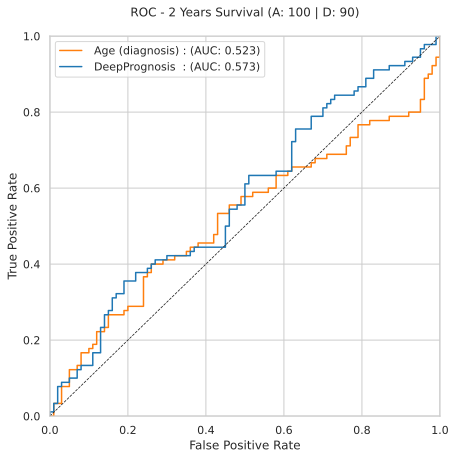

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))

sub_df = extension_df[~extension_df["age"].isna()]

alive_2y = np.sum(sub_df["surv_2y"].values)
dead_2y = len(sub_df) - alive_2y

colors = ["tab:orange",
          "tab:blue"]
    
get_roc_fig(axis = ax,
            colors = colors,
            event = 1 - sub_df["surv_2y"].values,
            event_name = "2 Years Survival (A: %g | D: %g)"%(alive_2y, dead_2y),
            predictors_list = [sub_df["age"].values,
                               np.stack(sub_df["CNN_output_raw"])[:, 0],
                              ],
            predictors_names = [" Age (diagnosis)",
                                " DeepPrognosis "],
           )

---

### KM Survival Curves

In [18]:
sub_df = extension_df
sub_df["surv_prob"] = np.stack(sub_df["CNN_output_raw"])[:, 0]

## ----------------------------------------

surv_q1 = sub_df[sub_df["surv_prob"] <= median_tuning]
surv_q2 = sub_df[sub_df["surv_prob"] > median_tuning]

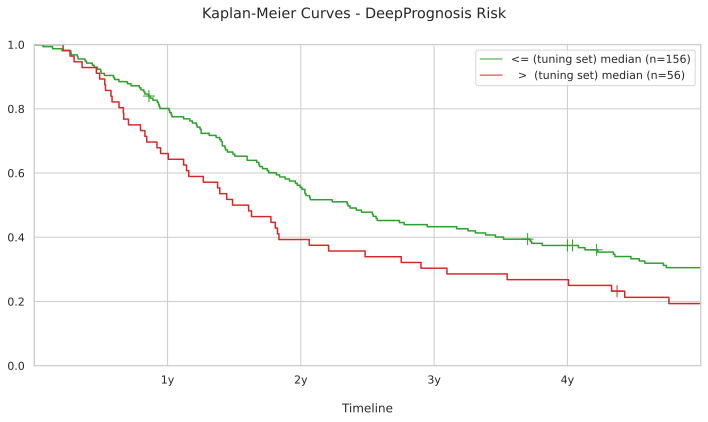

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

subgroups_to_plot = [surv_q1, surv_q2]

subgroup_labels = ["<= (tuning set) median (n=%g)"%(len(surv_q1)),
                   "  >  (tuning set) median (n=%g)"%(len(surv_q2))]

subgroup_colors = ['tab:green', 'tab:red']

leg_list = plot_km(axis = ax,
                   subgroups_to_plot = subgroups_to_plot,
                   labels = subgroup_labels,
                   colors = subgroup_colors)

plt.legend(leg_list, subgroup_labels)
fig.suptitle("Kaplan-Meier Curves - DeepPrognosis Risk")
fig.tight_layout(rect = [0, 0., 1, 0.995])